In [1]:
import sys
sys.path.insert(0, "../")
import numpy as np
import torch
from dataset import create_dataset_approx
from structure_compare.compare_pairs import StructureComparePair

/home/acowlagi/envs/torch_py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading Data

In [2]:
train_set, _, _, test_set = create_dataset_approx("cifar10")
x_train, y_train, x_test, y_test = train_set.data/255.0, train_set.targets, test_set.data/255.0, test_set.targets

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/home/acowlagi/2022-experiments/encoding-structures-of-neural-representations/notebooks/../dataset.py:47: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  data1_list.append(dataset.data[idx][:n1//(d+1)])
/home/acowlagi/2022-experiments/encoding-structures-of-neural-representations/notebooks/../dataset.py:48: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, roundin

### Computing Distance between Classes

In [3]:
class_0_examples, class_1_examples = x_train[y_train == 4], x_train[y_train == 9]
class_0_examples = class_0_examples.reshape(class_0_examples.shape[0], -1)
class_1_examples = class_1_examples.reshape(class_1_examples.shape[0], -1)
class_1_examples = np.random.randn(*class_1_examples.shape)
class_0_examples = np.random.randn(*class_0_examples.shape)

all_examples = x_train.reshape(x_train.shape[0], -1)

compare_pair = StructureComparePair(x1= class_0_examples, x2= class_1_examples, retain_var= 0.99)


In [4]:
block_sizes = [1, 10, 40, 100, 200]
distance_scores = []
for block_size in block_sizes:
    curr_block_size_score = []
    for thresh_start in range(0, block_size * (compare_pair.retained_vals // block_size), block_size):
        curr_block_size_score.append(compare_pair.compare_structure(threshold_start=thresh_start, threshold_end=thresh_start+block_size))

    distance_scores.append((curr_block_size_score, block_size))

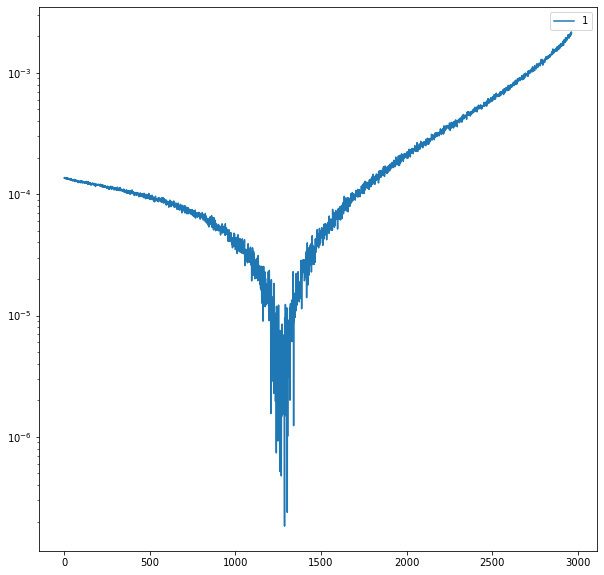

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

for (block_size_dist, block_size) in distance_scores:
    indices = np.arange(start = 0, stop = block_size * (compare_pair.retained_vals // block_size), step = block_size)
    ax.plot(indices, block_size_dist/(np.sqrt(block_size)), label = block_size)
    ax.set_yscale("log")
    break
ax.legend()

### Comparing Projection Coefficients using 2-Sample T-Test

In [8]:
from scipy.stats import ttest_ind

max_val = compare_pair.retained_vals
t_stats = []
pvals = []

for ind in range(0, max_val, 5):
    x1_coefficients_ind = compare_pair.x1_proj_coeffs[:, ind]
    x2_coefficients_ind = compare_pair.x2_proj_coeffs[:, ind]
    t_stat, p = ttest_ind(x1_coefficients_ind, x2_coefficients_ind)
    t_stats.append(t_stat)
    pvals.append(p)

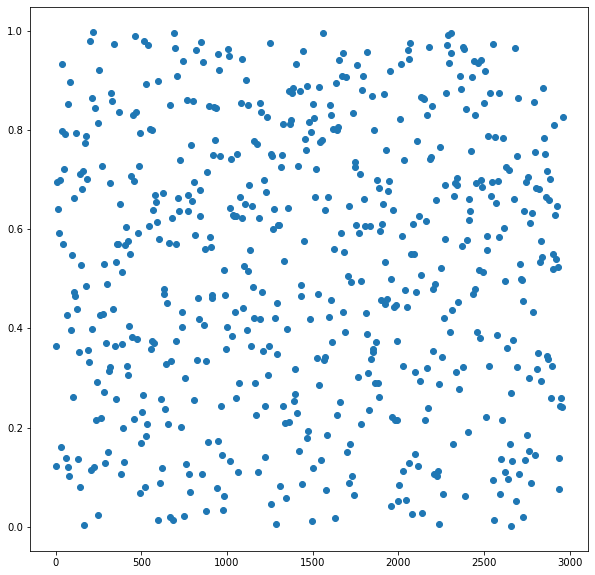

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.scatter(np.arange(start = 0, stop = max_val, step = 5), np.array(pvals))
# ax.set_xscale("log")

(array([43., 54., 53., 66., 60., 55., 84., 59., 65., 54.]),
 array([0.00108296, 0.10084608, 0.20060921, 0.30037233, 0.40013545,
        0.49989858, 0.5996617 , 0.69942482, 0.79918795, 0.89895107,
        0.99871419]),
 <BarContainer object of 10 artists>)

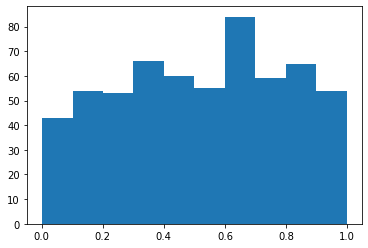

In [10]:
plt.hist(pvals)